In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.utils import Sequence

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy as scipy_entropy


Mounted at /content/drive


In [2]:
import os

for root, dirs, files in os.walk("/content/drive"):
    if "train" in dirs and "val" in dirs and "test" in dirs and "NORMAL" in os.listdir(os.path.join(root, "train")):
        print("✅ FOUND:", root)

✅ FOUND: /content/drive/MyDrive/chest_Xray
✅ FOUND: /content/drive/.Encrypted/MyDrive/chest_Xray


In [3]:
DATA_ROOT = "/content/drive/MyDrive/chest_Xray"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
def list_images(root):
    items = []
    for lbl, cls in enumerate(["NORMAL", "PNEUMONIA"]):
        folder = os.path.join(root, cls)
        for ext in ("*.jpeg", "*.jpg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
            items += [(f, lbl) for f in glob(os.path.join(folder, ext))]
    return items

splits = {
    s: list_images(os.path.join(DATA_ROOT, s))
    for s in ["train", "val", "test"]
}

In [5]:
def compute_classical_features(img, n=32):
    vals = img.flatten()
    hist, _ = np.histogram(vals, bins=64, range=(0, 1), density=True)

    quant = np.floor(img * (n - 1)).astype(np.uint8)
    glcm = graycomatrix(quant, distances=[1], angles=[0], levels=n,
                        symmetric=True, normed=True)
    def g(p): return float(np.mean(graycoprops(glcm, p)))

    return np.array([
        np.mean(vals), np.std(vals), np.min(vals), np.max(vals),
        scipy_entropy(hist + 1e-12),
        g('contrast'), g('homogeneity'), g('energy'),
        g('correlation'), g('dissimilarity'), g('ASM')
    ], dtype=np.float32)

In [6]:
records = {}
for split in ["train", "val", "test"]:
    rec = []
    for path, label in tqdm(splits[split], desc=f"Extracting {split}"):
        img = imread(path)
        if img.ndim == 3:
            img = rgb2gray(img)
        img = resize(img, (IMG_SIZE, IMG_SIZE), preserve_range=True)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        feats = compute_classical_features(img)
        rec.append({"path": path, "feats": feats, "label": label})
    records[split] = rec

Extracting test: 100%|██████████| 624/624 [07:08<00:00,  1.45it/s]


In [7]:
def check_features(name):
    bad = [
        r for r in records[name]
        if not isinstance(r["feats"], np.ndarray)
        or r["feats"].shape != (11,)
        or not np.isfinite(r["feats"]).all()
    ]
    print(f"Split {name}: total={len(records[name])}, bad={len(bad)}")
    return bad

bad_train = check_features("train")
bad_val   = check_features("val")
bad_test  = check_features("test")

Split train: total=5216, bad=0
Split val: total=16, bad=0
Split test: total=624, bad=0


In [8]:
valid_train_feats = np.stack([
    r["feats"] for r in records["train"]
    if r["feats"].shape == (11,) and np.isfinite(r["feats"]).all()
])

scaler = StandardScaler()
scaler.fit(valid_train_feats)

print("Scaler mean shape:", scaler.mean_.shape)


Scaler mean shape: (11,)


In [21]:
# Recompute class weights
y_train = np.array([r["label"] for r in records["train"]])

cw_values = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

cw = {0: cw_values[0], 1: cw_values[1]}
print("Class weights:", cw)


Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [22]:
class HybridSeq(Sequence):
    def __init__(self, recs, batch=BATCH_SIZE):
        self.recs = [
            r for r in recs
            if isinstance(r["feats"], np.ndarray)
            and r["feats"].shape == (11,)
            and np.isfinite(r["feats"]).all()
        ]
        self.batch = batch

    def __len__(self):
        return (len(self.recs) + self.batch - 1) // self.batch

    def __getitem__(self, idx):
        start = idx * self.batch
        end   = min(start + self.batch, len(self.recs))
        batch = self.recs[start:end]

        # SAFETY: If empty batch → return dummy valid batch
        if len(batch) == 0:
            return (
                (np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32),
                 np.zeros((1, 11), dtype=np.float32)),
                np.zeros((1,))
            )

        imgs, feats, labels = [], [], []

        for r in batch:
            try:
                img = imread(r["path"])
                img = resize(img, (IMG_SIZE, IMG_SIZE), preserve_range=True)
                if img.ndim == 2:
                    img = np.stack([img, img, img], axis=-1)

                img = effnet_preprocess(img.astype(np.float32))
                imgs.append(img)

                # ALWAYS SAFE FEATURE
                f = r["feats"]
                if not isinstance(f, np.ndarray) or f.shape != (11,) or not np.isfinite(f).all():
                    f = np.zeros(11, dtype=np.float32)
                feats.append(f)

                labels.append(r["label"])

            except:
                imgs.append(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32))
                feats.append(np.zeros(11, dtype=np.float32))
                labels.append(r["label"])

        imgs  = np.array(imgs, dtype=np.float32)
        feats = np.array(feats, dtype=np.float32)
        labels = np.array(labels, dtype=np.float32)

        # FINAL PROTECTION (NEVER EMPTY)
        if feats.ndim != 2 or feats.shape[1] != 11:
            print("Fixing broken feats at batch", idx)
            feats = np.zeros((imgs.shape[0], 11), dtype=np.float32)

        # NOW SAFE TO SCALE
        feats = scaler.transform(feats)

        return (imgs, feats), labels


In [25]:
train_seq = HybridSeq(records["train"])
val_seq   = HybridSeq(records["val"])
test_seq  = HybridSeq(records["test"])


In [24]:
for i, (x, y) in enumerate(test_seq):
    print(i, x[1].shape)



Streaming output truncated to the last 5000 lines.
1575392 (1, 11)
1575393 (1, 11)
1575394 (1, 11)
1575395 (1, 11)
1575396 (1, 11)
1575397 (1, 11)
1575398 (1, 11)
1575399 (1, 11)
1575400 (1, 11)
1575401 (1, 11)
1575402 (1, 11)
1575403 (1, 11)
1575404 (1, 11)
1575405 (1, 11)
1575406 (1, 11)
1575407 (1, 11)
1575408 (1, 11)
1575409 (1, 11)
1575410 (1, 11)
1575411 (1, 11)
1575412 (1, 11)
1575413 (1, 11)
1575414 (1, 11)
1575415 (1, 11)
1575416 (1, 11)
1575417 (1, 11)
1575418 (1, 11)
1575419 (1, 11)
1575420 (1, 11)
1575421 (1, 11)
1575422 (1, 11)
1575423 (1, 11)
1575424 (1, 11)
1575425 (1, 11)
1575426 (1, 11)
1575427 (1, 11)
1575428 (1, 11)
1575429 (1, 11)
1575430 (1, 11)
1575431 (1, 11)
1575432 (1, 11)
1575433 (1, 11)
1575434 (1, 11)
1575435 (1, 11)
1575436 (1, 11)
1575437 (1, 11)
1575438 (1, 11)
1575439 (1, 11)
1575440 (1, 11)
1575441 (1, 11)
1575442 (1, 11)
1575443 (1, 11)
1575444 (1, 11)
1575445 (1, 11)
1575446 (1, 11)
1575447 (1, 11)
1575448 (1, 11)
1575449 (1, 11)
1575450 (1, 11)
15754

KeyboardInterrupt: 

In [26]:
def build_model():
    img_in = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    feat_in = layers.Input((11,))

    base = EfficientNetB0(include_top=False, weights="imagenet")
    base.trainable = False

    x = base(img_in)
    x = layers.GlobalAveragePooling2D()(x)

    y = layers.Dense(64, activation="relu")(feat_in)

    z = layers.Concatenate()([x, y])
    z = layers.Dense(128, activation="relu")(z)
    z = layers.Dropout(0.3)(z)

    out = layers.Dense(1, activation="sigmoid")(z)

    model = models.Model([img_in, feat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC()]
    )
    return model

model = build_model()


In [27]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS,
    class_weight=cw
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7883 - auc_2: 0.6895 - loss: 0.5684

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 752s 5s/step - accuracy: 0.7886 - auc_2: 0.6907 - loss: 0.5677 - val_accuracy: 0.8750 - val_auc_2: 1.0000 - val_loss: 0.2921
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 728s 4s/step - accuracy: 0.8777 - auc_2: 0.9208 - loss: 0.2693 - val_accuracy: 0.8750 - val_auc_2: 1.0000 - val_loss: 0.3088
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 720s 4s/step - accuracy: 0.9110 - auc_2: 0.9577 - loss: 0.2296 - val_accuracy: 0.9375 - val_auc_2: 1.0000 - val_loss: 0.1678
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.9200 - auc_2: 0.9471 - loss: 0.1907 - val_accuracy: 0.9375 - val_auc_2: 1.0000 - val_loss: 0.1319
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 728s 4s/step - accuracy: 0.9286 - auc_2: 0.9705 - loss: 0.1674 - val_accuracy: 0.9375 - val_auc_2: 1.0000 - val_loss: 0.1125
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 723s 4s/step - accuracy: 0.9406 - auc_2: 0.9626 - loss: 0.1413 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 0.0858
Epoch 7/10
163/163 ━━

In [31]:
# Predict all test data in one go
preds = model.predict(test_seq, verbose=1).ravel()

# True labels directly from the sequence
trues = np.array([r["label"] for r in test_seq.recs])

print(classification_report(trues, preds > 0.5))
print("AUC:", roc_auc_score(trues, preds))



20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       234
           1       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624

AUC: 0.9466031119877273


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

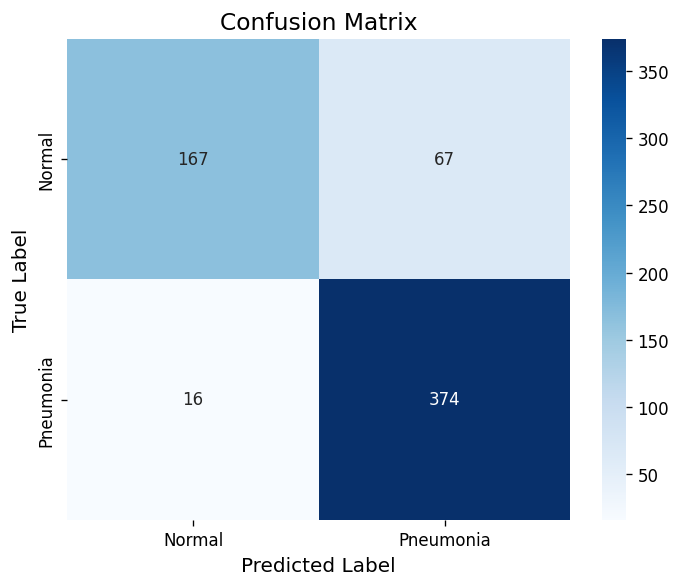

In [33]:
cm = confusion_matrix(trues, (preds > 0.5).astype(int))

plt.figure(figsize=(6,5), dpi=120)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

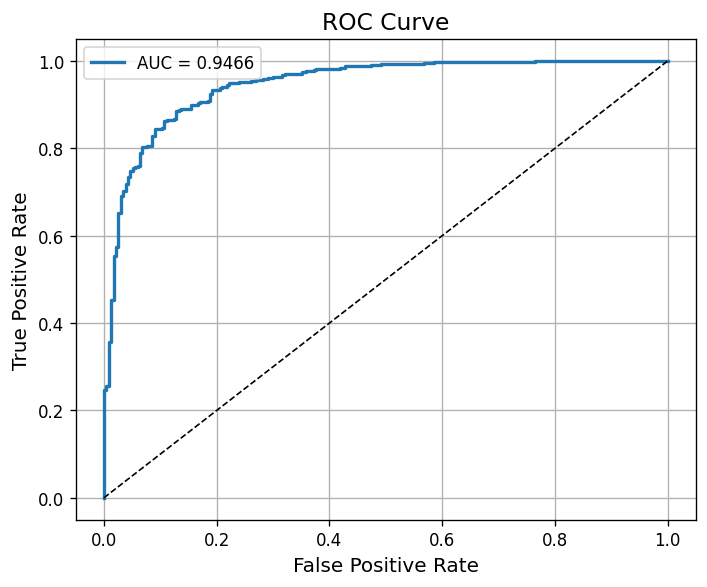

In [34]:
fpr, tpr, thresholds = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5), dpi=120)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0,1], [0,1], 'k--', linewidth=1)

plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

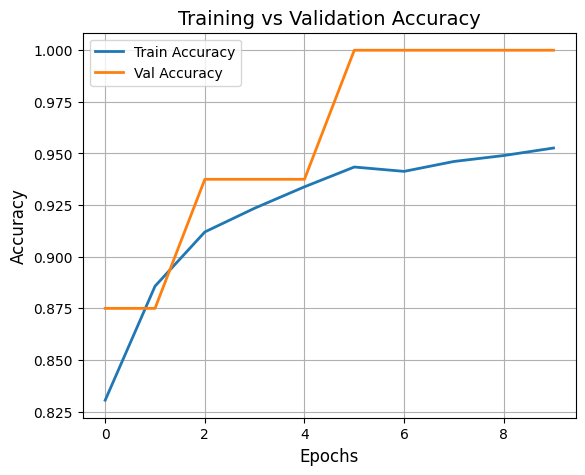

In [35]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Val Accuracy", linewidth=2)
plt.title("Training vs Validation Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)

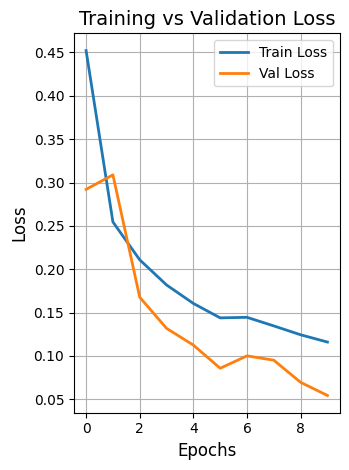

In [36]:
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Val Loss", linewidth=2)
plt.title("Training vs Validation Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

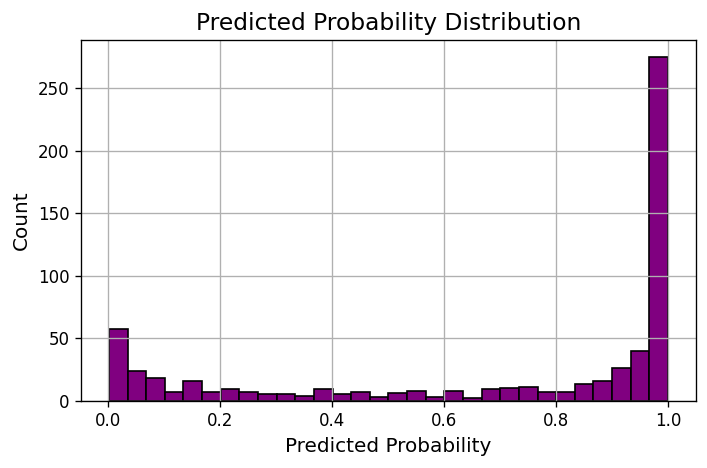

Final AUC Score = 0.9466031119877273


In [37]:
plt.figure(figsize=(6,4), dpi=120)
plt.hist(preds, bins=30, color='purple', edgecolor='black')
plt.title("Predicted Probability Distribution", fontsize=14)
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print AUC clearly
print("Final AUC Score =", roc_auc_score(trues, preds))